
## Project: **Finding Lane Lines on the Road** 

Our goal is, using some fairly straight-forward techniques, do a lane lines detection.


**The tools we have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection. **

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> First let's detect line segments</p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Then we will connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

## Import Packages

We will be using OpenCV (cv2) image processing package to do the job.

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

Reading in an test image: when using matplotlib, color channels are RGB; when cv2.imread - BGR

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


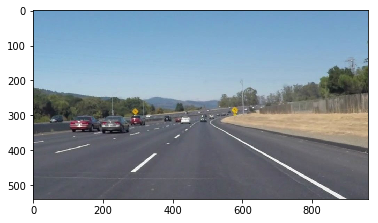

In [18]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteCurve.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')
plt.show()

**Some OpenCV functions that might also be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image


## Helper Functions

In [28]:
import math

DEBUG = True
IM_WIDTH = image.shape[1]
IM_HEIGHT = image.shape[0]

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lane_lines(img, lines, thickness=3):
    #calculates a weighted average from the input lines, discarding the ones which ms are don't look like lane markings
    #draws an image of lane lines
    #returns up to two pairs of lane line equation coefficients
    m = 0.0
    ml = 0.0
    mr = 0.0
    kl = 0.0
    kr = 0.0
    l = 0
    r = 0
    ln = 0
    w = img.shape[1]
    lane_eqs = np.empty((0,2), np.float32)    
    
    if not lines is None:
        for line in lines:
            for x1,y1,x2,y2 in line:
                if x1 != x2:
                    #interested in non-vertical lines only
                    m = (y2 - y1) / (x2 - x1)
                    k = y1 - m * x1
                    ln = int((pow(x2-x1,2) + pow(y2-y1,2))) #for weighted average
                    if m < -1/4:
                        #North-East facing line, discarding too horizontal ones
                        if min(x1, x2) < w / 2:
                        #not taking into account ones which are in the RIGHT part of the image: noise or a lane-change
                            l = l + ln
                            ml = ml + m * ln
                            kl = kl + k * ln
                    else: 
                        if m > 1/4:
                            #North-West facing line, discarding too horizontal ones
                            if min(x1, x2) > w / 2:
                                #not taking into account ones which are in the LEFT part of the image: noise or a lane-change
                                r = r + ln
                                mr = mr + m * ln
                                kr = kr + k * ln
    if (l > 0):
        #LEFT line detected (RED)
        ml = ml / l
        kl = kl / l
        lane_eqs = np.append(lane_eqs, [[ml, kl]], 0)
        x1 = 0
        y1 = int(kl)
        x2 = int(w / 2) - 10
        y2 = int(ml * x2 + kl)
        cv2.line(img, (x1, y1), (x2, y2), [255,0,0], thickness)
    else:
        lane_eqs = np.append(lane_eqs, [[0, 0]], 0)
    if (r > 0):
        #RIGHT line detected (GREEN)
        mr = mr / r
        kr = kr / r
        lane_eqs = np.append(lane_eqs, [[mr, kr]], 0)
        x1 = int(w / 2) + 10
        y1 = int(mr * x1 + kr)
        x2 = w
        y2 = int(mr * x2 + kr)
        cv2.line(img, (x1, y1), (x2, y2), [0,255,0], thickness)
    else:
        lane_eqs = np.append(lane_eqs, [[0, 0]], 0)
        
    return lane_eqs

def draw_hough_lines(img, lines, thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), [255,255,255], thickness)
            
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns LINES.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    return lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def imshow(img, cmap='gray'):
    if DEBUG:
        plt.imshow(img, cmap)
        plt.show()
        
def display_images_in_2_colums(images, captions=None, cmap=None):
    fig = plt.figure(figsize=(9, 3 * np.ceil(len(images) / 2.)))
    for i in range(len(images)):
        a = fig.add_subplot(np.ceil(len(images) / 2.), 2, i + 1)
        img = images[i]
        plt.imshow(img, cmap=cmap)
        if (not captions is None):
            a.set_title(captions[i])
    plt.show()        

## Test Images

Before applying the detection pipeline to a video stream, let'smake sure it can properly handle images in the directory "test_images".

In [4]:
import os
images = os.listdir("test_images/")
print(images)

['solidWhiteCurve.jpg', 'solidWhiteRight.jpg', 'solidYellowCurve.jpg', 'solidYellowCurve2.jpg', 'solidYellowLeft.jpg', 'vlcsnap-2017-03-20-20h52m55s385.jpg', 'vlcsnap-2017-03-21-13h07m51s177.jpg', 'vlcsnap-2017-03-21-22h41m23s083.jpg', 'whiteCarLaneSwitch.jpg']


## Lane Line Finding Pipeline



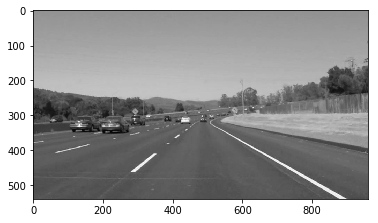

In [19]:
#converting input image to grayscale
gray = grayscale(img=image)
imshow(gray)

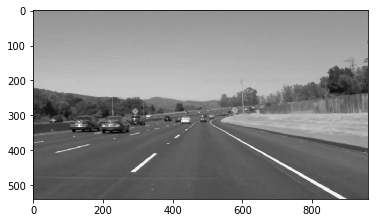

In [6]:
#gaussian blur
blured = gaussian_blur(img=gray, kernel_size=3)
imshow(blured)

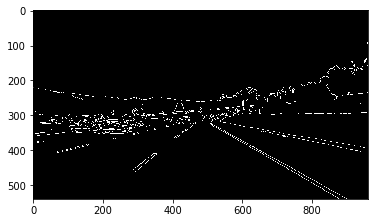

In [7]:
#canny edge detection

edges = canny(img=blured, low_threshold=50, high_threshold=150)
imshow(edges)

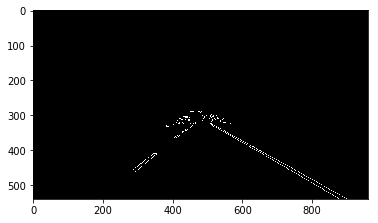

In [8]:
#region of interest
#this heavily depends on camera optics and its position
vertices = np.array([[
    (0, IM_HEIGHT - 1),
    (IM_WIDTH / 17 * 8, IM_HEIGHT / 2 + 20),
    (IM_WIDTH / 17 * 9, IM_HEIGHT / 2 + 20),
    (IM_WIDTH - 1, IM_HEIGHT - 1)
]],dtype=np.int32)
roi = region_of_interest(img=edges, vertices=vertices)
imshow(roi)
#print(IM_WIDTH, IM_HEIGHT, vertices)

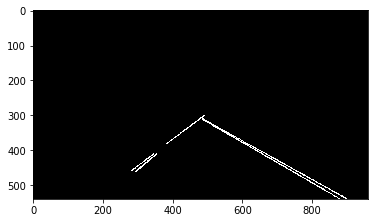

In [20]:
#using Hough Line transform to detect line segments from the Canny result
lines = hough_lines(img=roi, rho=1, theta=np.pi/180*1, threshold=50, min_line_len=50, max_line_gap=20)
h_lines = np.zeros((IM_HEIGHT, IM_WIDTH, 3), dtype=np.uint8)
draw_hough_lines(h_lines, lines)
imshow(h_lines)


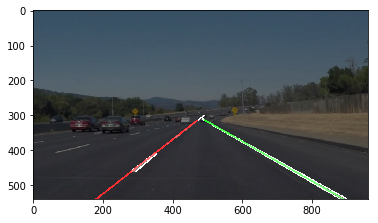

In [21]:
#drawing Haugh line segments on top of the original image
draw_lane_lines(img=h_lines,lines=lines)
imshow(weighted_img(h_lines, image, 0.5, 1))

We will keep a buffer of detected lines from a few recent frames here.

Previous_line_eqs contains Ms and Ks of earlier detected lanes, affecting weighted aggregation - 
this way we can still 'remember' where the lines were before if current frame is too hard to deduce from.
[
    #frame 1
    [m, k], #left line
    [m, k], #right line
    
    #frame 2
    [m, k], #left line
    [m, k],...
]

In [12]:
previous_line_eqs = np.ndarray((0, 2), np.float32)
FRAMES_TO_KEEP = 15 #half a second under 30fps ~~ about 15m under 65mph

In [24]:
def process_image(img):
    #putting all above together into single proc
    w = img.shape[1]
    h = img.shape[0]
    #ROI verices
    vs = np.array([[
        (0, h - 1),
        (w / 17 * 8, h / 2 + 20),
        (w / 17 * 9, h / 2 + 20),
        (w - 1, h - 1)
    ]],dtype=np.int32)
    
    #calculating a, geometrically declining in euclidean length, sequence of lines using provided previous_line_eqs
    i = 0
    ln = h*.75  #since the weight of line is defined by its length, the most recent lines will be longer,
                #progressively getting shorter towards the older frames
    x1 = y1 = x2 = y2 = alpha = 0.0
    sign = 1
    global previous_line_eqs
    previous_lines = np.empty((0,1,4), np.int)
    for m, k in previous_line_eqs:
        i = i + 1
        if m != 0: #interested in valid lines only
            if i % 2 == 1:
                #LEFT line
                x1 = 0
                sign = 1
            else:
                #RIGHT line
                x1 = w
                sign = -1
                
            alpha = np.arctan(m)
            y1 = m*x1 + k
            x2 = x1 + ln * np.cos(alpha) * sign
            y2 = y1 + ln * np.sin(alpha) * sign
            previous_lines = np.append(previous_lines, [[[int(x1), int(y1), int(x2), int(y2)]]], 0)
        
        if i % 2 == 0:
            ln = ln * .75; #frame is done, next frame lines will be shorter

    gray = grayscale(img=img)
    blured = gaussian_blur(img=gray, kernel_size=3)
    edges = canny(img=blured, low_threshold=50, high_threshold=150)
    roi = region_of_interest(img=edges, vertices=vs)
    lines = hough_lines(img=roi, rho=1, theta=np.pi/180*1, threshold=50, min_line_len=50, max_line_gap=20)
    lines = np.append(lines, previous_lines, 0) #adding lines from previous few frames
    h_lines = np.zeros((h, w, 3), dtype=np.uint8)
    lane_eqs = draw_lane_lines(img=h_lines,lines=lines)
    
#   uncomment to display effect of previously seen lines
    for line in previous_lines:
        for x1,y1,x2,y2 in line:
            cv2.line(h_lines, (x1, y1), (x2, y2), [0,0,255], 5)
    
    #inserting first the lane_lines to the rolling buffer previous_line_eqs, 
    #so we can count them in the next few frames
    previous_line_eqs = np.insert(previous_line_eqs, 0, lane_eqs, axis=0)
    while previous_line_eqs.shape[0] > FRAMES_TO_KEEP * 2: #keeping track of the last frames only (2 lines per frame)
        previous_line_eqs = np.delete(previous_line_eqs, previous_line_eqs.shape[0] - 1, 0)
    
    #drawing
    return weighted_img(h_lines, img, 0.5,1)    

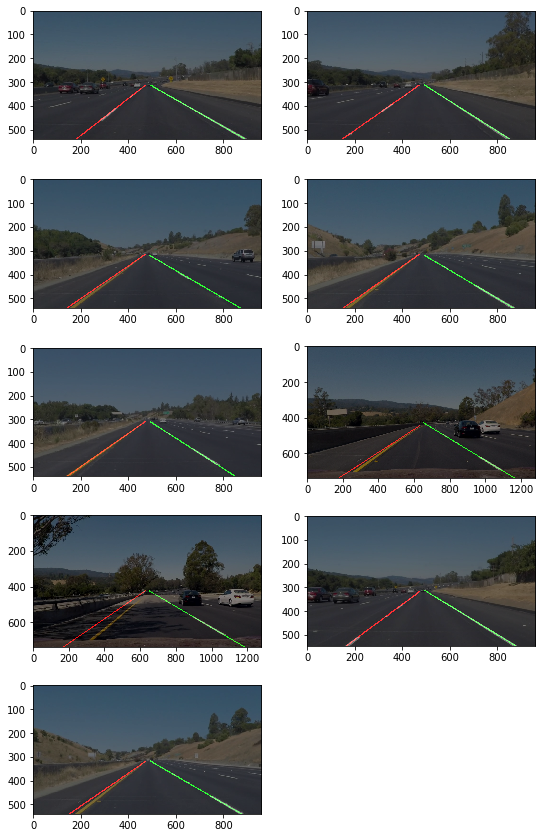

In [29]:
#running through set of test images
display_images = []
for im in images:
    image = mpimg.imread('test_images/' + im)
    previous_line_eqs = np.ndarray((0, 2), np.float32) #these are independent test images, resetting previous lanes
    processed_image = process_image(image)
    display_images.append(processed_image)
    mpimg.imsave( 'test_images_output/' + im, processed_image)
display_images_in_2_colums(display_images)

Looks like it worked!! but we could see few inaccuracies in the right line detection on the frames where there is a lot of light/shadow fluctuations. Let's see if somethign can be done by tracking lines through multiple recent frames...

## Test on Videos

So, you know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`


**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```


In [30]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [31]:
previous_line_eqs = np.ndarray((0, 2), np.float32)
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 221/222 [00:03<00:00, 66.92it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 3.81 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [32]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [33]:
previous_line_eqs = np.ndarray((0, 2), np.float32)
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 681/682 [00:10<00:00, 63.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 11.2 s


In [34]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## The Challenge

So far so good! Now let's do the most complicated from the set:

In [35]:
previous_line_eqs = np.ndarray((0, 2), np.float32)
challenge_output = 'test_videos_output/challenge.mp4'
clip2 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:07<00:00, 32.65it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 8.51 s


In [36]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))